In [12]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Read data

In [13]:
df = pd.read_csv(r"C:\Users\VTS\Downloads\ML Lithium Ion Battery\MaterialsProjectLiIonBattery.csv")

# Display the first few rows of the DataFrame
print(df.head())

     battery_id  id_charge id_discharge battery_formula framework_formula  \
0      mp-28_Li      mp-28   mp-1185231         Li0-3Ce                Ce   
1  mp-573471_Li  mp-573471   mp-1198729    Li4.25-4.4Sn                Sn   
2      mp-80_Li      mp-80      mp-7955         Li0-3Sb                Sb   
3     mp-124_Li     mp-124    mp-865875         Li0-3Ag                Ag   
4  mp-568806_Li  mp-568806   mp-1001581       Li0-0.17C                 C   

  formula_discharge formula_charge working_ion     V_avg  capacity_grav  \
0             Li3Ce             Ce          Li -0.444846     499.595769   
1           Li22Sn5        Li17Sn4          Li -0.840299      26.936090   
2             Li3Sb             Sb          Li  1.099595     563.913254   
3             Li3Ag             Ag          Li  0.163836     624.785871   
4              LiC6              C          Li  0.288598     339.236925   

   capacity_vol  energy_grav   energy_vol  max_delta_volume  stability_charge  \
0   1

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   battery_id                     2434 non-null   object 
 1   id_charge                      2434 non-null   object 
 2   id_discharge                   2434 non-null   object 
 3   battery_formula                2434 non-null   object 
 4   framework_formula              2434 non-null   object 
 5   formula_discharge              2434 non-null   object 
 6   formula_charge                 2434 non-null   object 
 7   working_ion                    2434 non-null   object 
 8   V_avg                          2434 non-null   float64
 9   capacity_grav                  2434 non-null   float64
 10  capacity_vol                   2434 non-null   float64
 11  energy_grav                    2434 non-null   float64
 12  energy_vol                     2434 non-null   f

In [33]:
df.describe()
df['formula_discharge']

0                   Li3Ce
1                 Li22Sn5
2                   Li3Sb
3                   Li3Ag
4                    LiC6
              ...        
2429       Li3VCrP2(HO5)2
2430        LiMnVP2(HO5)2
2431        LiVFeP2(O4F)2
2432    Li4Mn2Fe3Sn(PO4)6
2433      BaSrLiNdTlCu2O7
Name: formula_discharge, Length: 2434, dtype: object

# Prepare Input Variable

In [ ]:
# Get all unique elements in the data
def get_element_counts(formula):
    """
    Parses a chemical formula and returns a dictionary of element counts.
    Handles formulas like Li3Ce, Li22Sn5, etc.
    """
    counts = {}
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', str(Composition(formula)))
    for element, count_str in matches:
        count = int(count_str) if count_str else 1
        counts[element] = counts.get(element, 0) + count
    return counts

# Compositions of elements in the formula
def calculate_composition(element_counts): 
    """
    Calculates the atomic percentage composition from a dictionary of element counts.
    """
    total_atoms = sum(element_counts.values())
    if total_atoms == 0:
        return {}
    
    composition = {
        element: (count / total_atoms) * 100
        for element, count in element_counts.items()
    }
    return composition


# Apply the parsing and composition calculation to the 'formula_discharge' column
# (Ensuring these columns exist for the next step)
df['element_counts_discharge'] = df['formula_discharge'].apply(get_element_counts)
df['composition_discharge_percent'] = df['element_counts_discharge'].apply(calculate_composition)


# Convert the 'composition_discharge_percent' column (list of dictionaries)
# into a flat DataFrame where each key becomes a column.
X = pd.json_normalize(df['composition_discharge_percent'])


# Fill any NaN values (which occur when an element is not present in a formula) with 0.
X = X.fillna(0)



# TEST input (compositions)
# Display the first few rows of the prepared features (X)
print("First few-ish rows of the prepared features (X) for the ML model:")
print(X.head())
# print(X.head(30).to_markdown(index=False)) # tabularize the data

# print(X['Li'])

# Display the shape of X (number of rows, number of features/elements)
print(f"\nShape of X (samples, features/elements): {X.shape}")

# Display the columns (elements) in X
print("\nColumns (elements) in X:")
print(X.columns.tolist()[:10]) # Print first 10 columns for brevity

print(X.columns.shape)
print('\n', type(X))

First few-ish rows of the prepared features (X) for the ML model:
          Li    Ce         Sn    Sb    Ag          C   Bi   Ca   Cr   Nb  ...  \
0  75.000000  25.0   0.000000   0.0   0.0   0.000000  0.0  0.0  0.0  0.0  ...   
1  81.481481   0.0  18.518519   0.0   0.0   0.000000  0.0  0.0  0.0  0.0  ...   
2  75.000000   0.0   0.000000  25.0   0.0   0.000000  0.0  0.0  0.0  0.0  ...   
3  75.000000   0.0   0.000000   0.0  25.0   0.000000  0.0  0.0  0.0  0.0  ...   
4  14.285714   0.0   0.000000   0.0   0.0  85.714286  0.0  0.0  0.0  0.0  ...   

     H   Tm   Ru   Er   Ho   Tb   Sm   Nd   Pb   Ir  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 70 columns]

Shape of X (samples, features/elements): (2434, 70)

Columns (elements) in X:
['Li', 'Ce', 'Sn', 'S

# Target Variable

In [59]:
# TARGET VARIABLE
target = pd.read_csv(r'MPFormationEnergyBattery.csv')
y = target['formation_energy']

# Split Data

In [60]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ML's models

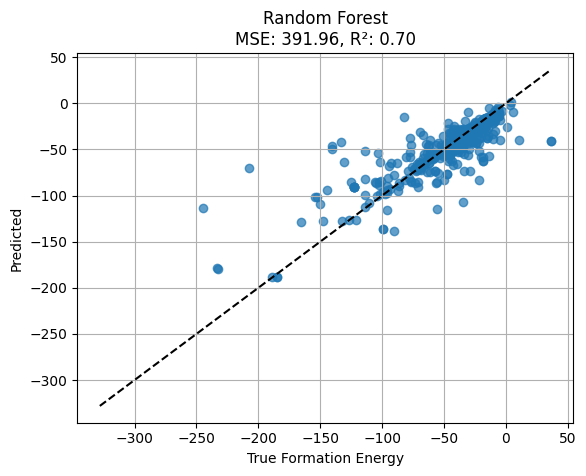

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

plt.figure()
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("True Formation Energy")
plt.ylabel("Predicted")
plt.title(f"Random Forest\nMSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")
plt.grid()
plt.show()


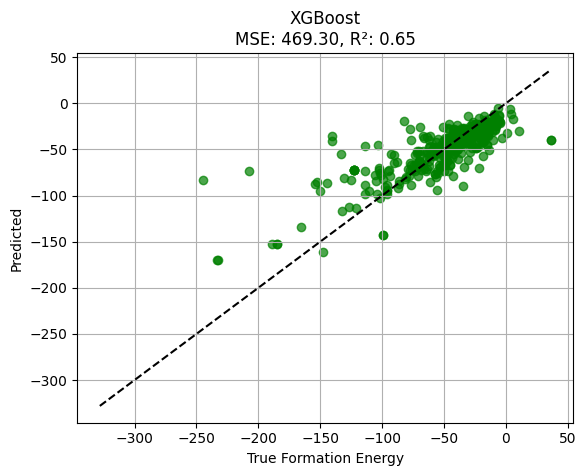

In [62]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

plt.figure()
plt.scatter(y_test, y_pred_xgb, alpha=0.7, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("True Formation Energy")
plt.ylabel("Predicted")
plt.title(f"XGBoost\nMSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")
plt.grid()
plt.show()


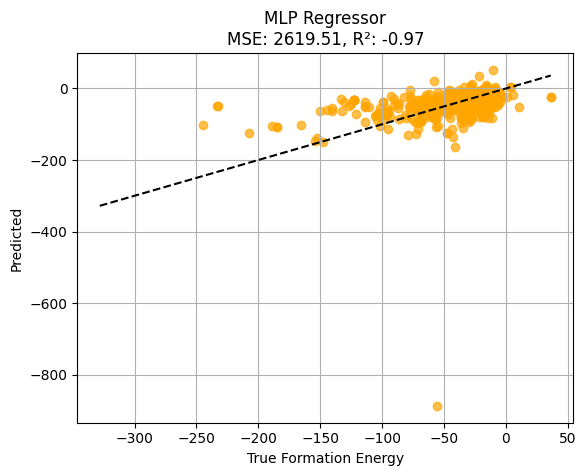

In [64]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

plt.figure()
plt.scatter(y_test, y_pred_mlp, alpha=0.7, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("True Formation Energy")
plt.ylabel("Predicted")
plt.title(f"MLP Regressor\nMSE: {mse_mlp:.2f}, R²: {r2_mlp:.2f}")
plt.grid()
plt.show()
